In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sn
import sys
from pathlib import Path
import os

from scipy.special import gamma as gamma

# import custom functions from src folder
module_path = str(Path.cwd() / "../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from util import *

In [2]:
def polar_to_cartesian_df(df, x_key, y_key, r_key, theta_key):
    df[x_key] = df[r_key]*np.cos(df[theta_key])
    df[y_key] = df[r_key]*np.sin(df[theta_key])
    return df

def cartesian_to_polar_df(df, x_key, y_key, r_key, theta_key):
    df[r_key] = np.sqrt(df[x_key]**2 + df[y_key]**2)
    df[theta_key] = np.arctan(df[y_key]/df[x_key])
    #Get angles in range 0, 2pi
    df_copy = df.copy()
    mask1 = df_copy[x_key] < 0
    df.loc[mask1, theta_key] = df[theta_key] + np.pi
    df_copy = df.copy()
    mask2 = df_copy[theta_key] < 0
    df.loc[mask2, theta_key] = df[theta_key] + 2*np.pi
    return df

### Datasets for classification with irreducible uncertainty

In particle physics, and in many other scientific fields, we set up an experiment of the relevant physics phenomenom we want to learn about and take measurements of some observables from that experiment. We then want to infer something about the underlying mathematical properties of the physics phenomenon. In the case of event or jet classification, we want to infer which one out of a discrete set of possible unstable particles produced the observed measurements in our detector. The problem is made more difficult by the fact that the problem is not 1-to-1/not deterministic/has irreducible uncertainty. This means that in general, more than one type of particle can result in the exact same measurement. This can be due to the fact that the processes themselves have overlap in the resulting distributon of particles, it can be due to smearing because of the finite resolution of the detector cells, or it can be due to the post-processing of the data. Typically, the raw measurements from the detector are translated into human-readable "high level features" such as the number of jets, their respective transverse momenta, reconstructed particles and their charge, etc. This dimensionality reduction results in possibly even more irreducible uncertainty in the distributions of the data, conditioned on the class, as information is lost in the process.

We have created a setup for generating synthetic datasets with this kind of overlapping conditional probability distributions. In this model we will consider all sources of irreducible uncertainty as one, and let the final conditional probability be modeled as a simple parametric function p(class | measurement) = $f(\vec{x}, \vec{\theta}(class))$.

Distributed features:
$
\begin{aligned}
& \vec{x} = [x^1, ..., x^d] \in X \subseteq \mathbb{R^d} \\
& \vec{c} = [c^1, ..., c^k],\in  c^j=1, c^i = 0 \text{ for } i \neq j \\
\end{aligned}
$


In [3]:
def gamma_distribution(x, shape, scale):
    k = shape
    t = scale
    p_x = x**(k-1)*np.exp(-x/t)/(t**k*gamma(k))
    return p_x

def p_r(r, c, shape_list, scale_list, p_c_list):
    k = len(p_c_list)
    return np.sum([p_r_given_c(r, i, shape_list, scale_list)*p_c_list[i] for i in range(k)], axis=0)

def p_r_given_c(r, c, shape_list, scale_list):
    shape = shape_list[c]
    scale = scale_list[c]
    return gamma_distribution(r, shape, scale)

def p_c_given_r(r, c, shape_list, scale_list, p_c_list):
    return p_r_given_c(r, c, shape_list, scale_list)*p_c_list[c]/p_r(r, c, shape_list, scale_list, p_c_list)


Index(['class', 'r', 'a1', 'a2', 'x1', 'x2', 'x3', 'p_c0', 'p_r_given_c0',
       'p_c0_given_r', 'p_r', 'x1_check', 'x2_check', 'x3_check', 'r_check'],
      dtype='object')


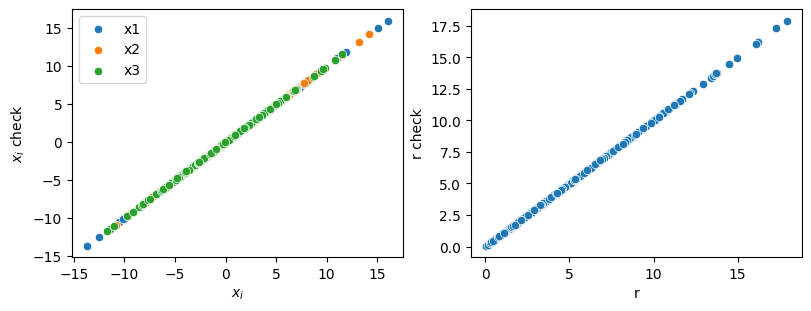

In [4]:
def simulate(shape_list, scale_list, p_c_list, d:int, n:int, seed:int=100):
    rng = np.random.default_rng(seed=seed)
    num_classes = len(scale_list)
    classes = np.arange(0, num_classes)
    c = rng.choice(classes, n, p=p_c_list)
    r = np.zeros(n) # Radii
    a = np.zeros((d, n)) #Angles
    for i in range(num_classes):
        r = np.where(c==i, rng.gamma(shape_list[i], scale_list[i], n), r)
        for j in range(d):
            if j < d-2: #The n-2 first dimensions [0, pi]
                a[j] = rng.uniform(0, np.pi, n)
            else: #The last dimension [0, 2pi]
                a[j] = rng.uniform(0, 2*np.pi, n)
    keys = ["class"]
    df = pd.DataFrame(columns=keys)
    df["class"] = c
    df["r"] = r
    for i in range(0, d-1):
        df[f"a{i+1}"] = a[i]
    df["x1"] = r*np.cos(df[f"a1"]) #x1 = r*cos(a1)
    # Iterate over x_j from j=2 to j=d
    for j in range(2, d+1):
        val = np.ones(n)
        if j == d: # works
            # val = sin(a1*sin(a2)*..*sin(d-2)
            for k in range(1, j-1): # k = 1, ..., j-2
                val = val*np.sin(df[f"a{k}"])
            df[f"x{j}"] = r*val*np.sin(df[f"a{j-1}"])
        else:
            # val = sin(a1*sin(a2)*..*sin(j-1)
            for k in range(1, j): # k = 1, ..., j-2
                val = val*np.sin(df[f"a{k}"])
            df[f"x{j}"] = r*val*np.cos(df[f"a{j}"])
    # Add analytical solution
    for c in range(0, num_classes):
        df[f"p_c{c}"] = p_c_list[c]
        df[f"p_r_given_c{c}"] = p_r_given_c(r, c, shape_list, scale_list)
        df[f"p_c{c}_given_r"] = p_c_given_r(r, c, shape_list, scale_list, p_c_list)
    df[f"p_r"] = p_r(r, c, shape_list, scale_list, p_c_list) 
    return df

def analytical_grid_cartesian(shape_list, scale_list, p_c_list, d:int, nx:int=100, rmax:float=30.0):
    #Just implement for 2D for now
    keys = ["r"]
    df = pd.DataFrame(columns=keys)
    num_classes = len(p_c_list)
    if d == 2:
        x1 = np.linspace(-rmax, rmax, nx)
        x2 = np.linspace(-rmax, rmax, nx)
        xx1, xx2 = np.meshgrid(x1, x2)
        df = pd.DataFrame(columns = ["x1", "x2"], index = range(len(xx1.flatten())))
        df["x1"] = xx1.flatten()
        df["x2"] = xx2.flatten()
        df = cartesian_to_polar_df(df, "x1", "x2", "r", "a1") # From util
        # Calculate probabilities
        for c in range(0, num_classes):
            df[f"p_c{c}"] = p_c_list[c]
            df[f"p_r_given_c{c}"] = p_r_given_c(df["r"], c, shape_list, scale_list)
            df[f"p_c{c}_given_r"] = p_c_given_r(df["r"], c, shape_list, scale_list, p_c_list)
        df[f"p_r"] = p_r(df["r"], c, shape_list, scale_list, p_c_list)
        return df
    else:
        print("Not supported for d != 2 yet...")
        return df

def analytical_grid_polar(shape_list, scale_list, p_c_list, d:int, nr:int=100, na:int=10, rmax:float=1000.0, rmin:float=0.0):
    #Just implement for 2D for now
    keys = ["r"]
    df = pd.DataFrame(columns=keys)
    num_classes = len(p_c_list)
    if d == 2:
        r = np.logspace(0, np.log10(rmax), nr)
        r[0] = 0.1
        n_a1 = np.arange(0, na, dtype=int)
        rr, n_aa1 = np.meshgrid(r, n_a1)
        df = pd.DataFrame(columns = ["r", "a1"], index = range(len(rr.flatten())))
        df["r"] = rr.flatten()
        df["n_a1"] = n_aa1.flatten()
        df["a1"] = ((2*np.pi/na)*df["n_a1"])
        df = polar_to_cartesian_df(df, "x1", "x2", "r", "a1") # From util
        # Calculate probabilities
        for c in range(0, num_classes):
            df[f"p_c{c}"] = p_c_list[c]
            df[f"p_r_given_c{c}"] = p_r_given_c(df["r"], c, shape_list, scale_list)
            df[f"p_c{c}_given_r"] = p_c_given_r(df["r"], c, shape_list, scale_list, p_c_list)
        df[f"p_r"] = p_r(df["r"], c, shape_list, scale_list, p_c_list)
        return df
    else:
        print("Not supported for d != 2 yet...")
        return df


def test_polar_coordinates():
    #Test that it works in 3D
    shapes = [2]
    scales = [2]
    k = len(scales) # Number of classes
    d = 3 # Number of dimensions
    p_c = [1/len(shapes)]*len(shapes) # Uniform distributon over classes
    seed = 24
    df = simulate(shapes, scales, p_c, d, n=1000, seed=seed)
    #a1 = theta, [0, pi]
    #a2 = phi, [0, 2pi]
    df["x1_check"] = df["r"]*np.cos(df["a1"])
    df["x2_check"] = df["r"]*np.sin(df["a1"])*np.cos(df["a2"])
    df["x3_check"] = df["r"]*np.sin(df["a1"])*np.sin(df["a2"])
    df["r_check"] = np.sqrt(df["x1"]**2+df["x2"]**2+df["x3"]**2)
    print(df.keys())
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (8, 3), layout="constrained")
    for i in range(1, d+1):
        sn.scatterplot(df, x=f"x{i}", y = f"x{i}_check", label=f"x{i}", ax=axs[0])
    axs[0].set_xlabel(r"$x_i$")
    axs[0].set_ylabel(r"$x_i$ check")
    sn.scatterplot(df, x="r", y="r_check", ax=axs[1])
    axs[1].set_ylabel(r"r check")

test_polar_coordinates()

In [56]:
SAVE = False
# Choose parameters
shapes = [2, 9]
scales = [5, 3]
k = len(scales) # Number of classes
d = 2 # Number of dimensions
p_c = [0.5, 0.5]
#[1/len(shapes)]*len(shapes) # Uniform distributon over classes
seed = 24
#grid_rmax=30

avg_mean = p_c[0]*shapes[0]*scales[0]+ p_c[1]*shapes[1]*scales[1]
avg_var = p_c[0]*shapes[0]*scales[0]**2+ p_c[1]*shapes[1]*scales[1]**2
grid_rmax = avg_mean + 5*avg_var**(1/2) #df["r"].max()

train_df = simulate(shapes, scales, p_c, d=d, n=50000, seed=seed)
test_df = simulate(shapes, scales, p_c, d=d, n=1000, seed=seed)
val_df = simulate(shapes, scales, p_c, d=d, n=5000, seed=seed)
grid_df = analytical_grid_cartesian(shapes, scales, p_c, d, nx=100, rmax=grid_rmax)
large_grid_df = analytical_grid_polar(shapes, scales, p_c, d=2, nr=500, na=5, rmax=1000)

In [6]:
# Max accuracy on test set
max_acc = np.sum(train_df[[f"p_c{i}_given_r" for i in range(k)]].max(axis=1))/len(train_df)
print("Max acc train data: ", max_acc)
max_acc = np.sum(test_df[[f"p_c{i}_given_r" for i in range(k)]].max(axis=1))/len(test_df)
print("Max acc test data: ", max_acc)

Max acc train data:  0.7405497427147698
Max acc test data:  0.7385207198110306


### Save datasets

In [7]:
# Save data only if it does not already exist
def save_file(df, filename):
    if os.path.isfile(filename):
        print("File already exists. To replace, manually override.")
    else:
        df.to_csv(filename, index=False)

tag = f'k_{k}_d{d}_shapes{shapes}_scales{scales}_pc{p_c}'.replace(" ", "")
if SAVE:
    trainfile = f'data/train_n_{len(train_df)}_{tag}.csv'
    save_file(train_df, trainfile)
    valfile = f'data/val_n_{len(val_df)}_{tag}.csv'
    save_file(val_df, valfile)
    testfile = f'data/test_n_{len(test_df)}_{tag}.csv'
    save_file(test_df, testfile)
    if len(grid_df) > 0:
        gridfile = f'data/grid_x1_x2_{len(grid_df)}_{tag}.csv'
        save_file(grid_df, gridfile)

    if len(large_grid_df) > 0:
        gridfile = f'data/grid_r_a1_{len(large_grid_df)}_{tag}.csv'
        save_file(large_grid_df, gridfile)


In [8]:
np.sqrt(0.6*(1-0.6)/(3))

0.282842712474619

### Plot datasets and distributions

Text(0.5, 0.98, 'Training data')

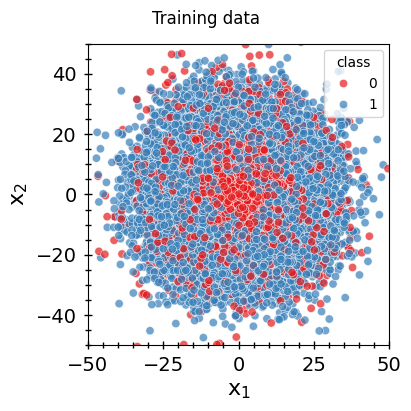

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize= (4, 4), layout="constrained")
color = ["#e41a1c", "#377eb8"]
sn.scatterplot(train_df, x="x1", y="x2", hue="class", palette=color,
               alpha=0.7, ax = ax)
ax.set_xlabel(r"x$_1$", fontsize=16)
ax.set_ylabel(r"x$_2$", fontsize=16)
ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
ax.tick_params(which="major", length=6)
ax.minorticks_on()
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-grid_rmax, grid_rmax)
ax.set_ylim(-grid_rmax, grid_rmax)
fig.suptitle("Training data")

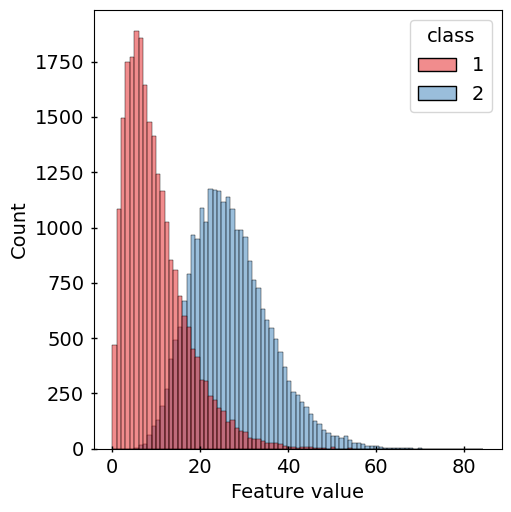

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize= (5,5), layout="constrained")
sn.histplot(train_df, x=f"r", hue="class", palette=color, ax = ax, stat="count")
ax.set_xlabel("Feature value", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
old_legend = ax.legend_
handles = old_legend.legendHandles
labels = [f"{int(t.get_text())+1}" for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
ax.legend(handles, labels, fontsize=14, title=title, title_fontsize=14)
fig.savefig(f"fig/classification_example.pdf", format="pdf", bbox_inches='tight', dpi=350)

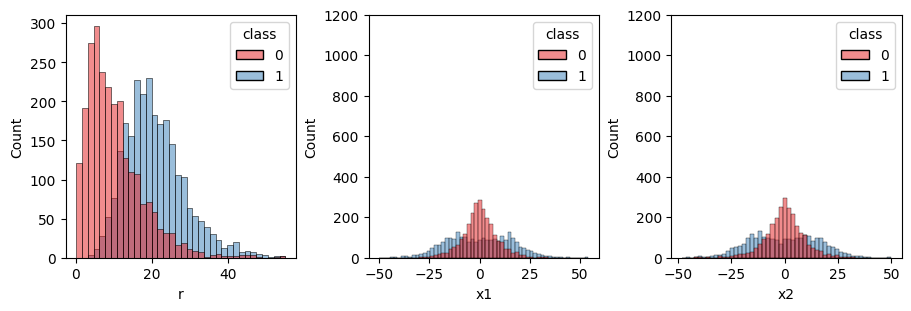

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=d+1, figsize= (3*(d+1), 3), layout="constrained")
sn.histplot(train_df, x=f"r", hue="class", palette=color, ax = axs[0])
for i in range(1, d+1):
    sn.histplot(train_df, x=f"x{i}", hue="class", palette=color, ax = axs[i])
    axs[i].set_ylim(0, 1200)
    #axs[i].set_xlim(-30, 30)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


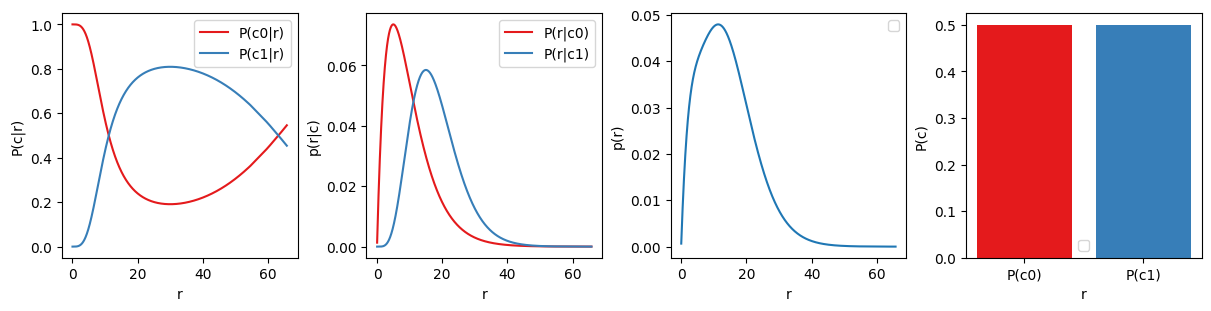

In [11]:
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (12, 3), layout="constrained")
for i in range(k):
    sn.lineplot(train_df, x="r", y=f"p_c{i}_given_r", label=f"P(c{i}|r)", ax=axs[0], c=color[i])
    axs[0].set_ylabel(r"P(c|r)")
    sn.lineplot(train_df, x="r", y=f"p_r_given_c{i}", label=f"P(r|c{i})", ax=axs[1], c=color[i])
    axs[1].set_ylabel(r"p(r|c)")
    axs[3].bar(x=[f"P(c{i})" for i in range(k)], height=p_c, color=color)
    axs[3].set_ylabel(f"P(c)")
sn.lineplot(train_df, x="r", y="p_r", ax=axs[2])
axs[2].set_ylabel("p(r)")
for ax in axs:
    ax.legend()
    ax.set_xlabel("r")
    #ax.set_xlim(0, 30)


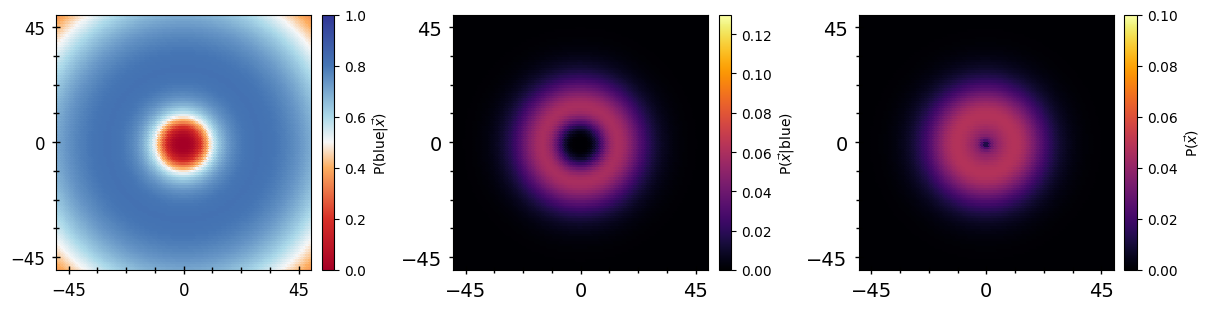

In [12]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 6), layout="constrained")

axs[0] = plot_results(grid_df, "p_c1_given_r", axs[0], "", grid=True, rmax=grid_rmax)
hue_norm_prob = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_prob, cmap=red_blue_cmap()),  fraction=0.050, pad=0.04,
                 label=r"P(blue|$\vec{x}$)", ax=axs[0])

axs[1] = plot_std(grid_df, "p_r_given_c1", axs[1], "", max_val=0.13, grid=True, rmax=grid_rmax)

hue_norm_prob = mpl.colors.Normalize(vmin=0, vmax=0.13, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_prob, cmap="inferno"),  fraction=0.050, pad=0.04,
                 label=r"P($\vec{x}$|blue)", ax=axs[1])

axs[2] = plot_std(grid_df, "p_r", axs[2], "", max_val=0.10, grid=True, rmax=grid_rmax)

hue_norm_prob = mpl.colors.Normalize(vmin=0, vmax=0.10, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_prob, cmap="inferno"),  fraction=0.050, pad=0.04,
                 label=r"P($\vec{x}$)", ax=axs[2])

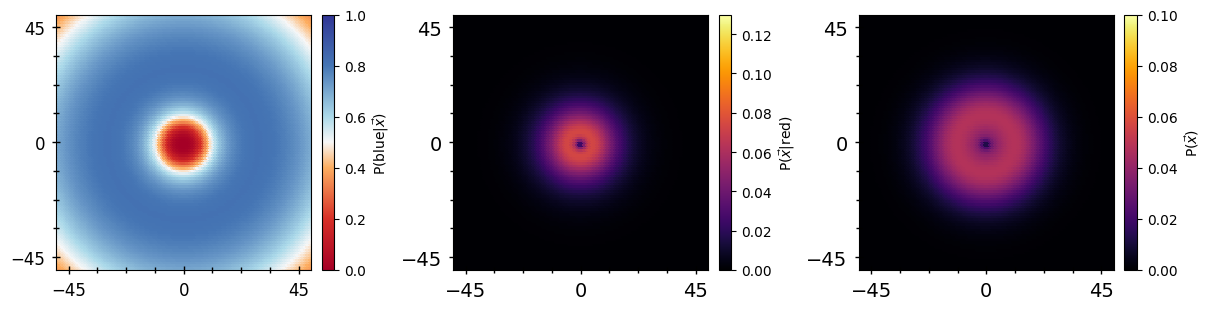

In [13]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 6), layout="constrained")

axs[0] = plot_results(grid_df, "p_c1_given_r", axs[0], "", grid=True, rmax=grid_rmax)
hue_norm_prob = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_prob, cmap=red_blue_cmap()),  fraction=0.050, pad=0.04,
                 label=r"P(blue|$\vec{x}$)", ax=axs[0])

axs[1] = plot_std(grid_df, "p_r_given_c0", axs[1], "", max_val=0.13, grid=True, rmax=grid_rmax)

hue_norm_prob = mpl.colors.Normalize(vmin=0, vmax=0.13, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_prob, cmap="inferno"),  fraction=0.050, pad=0.04,
                 label=r"P($\vec{x}$|red)", ax=axs[1])

axs[2] = plot_std(grid_df, "p_r", axs[2], "", max_val=0.1, grid=True, rmax=grid_rmax)

hue_norm_prob = mpl.colors.Normalize(vmin=0, vmax=0.1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_prob, cmap="inferno"),  fraction=0.050, pad=0.04,
                 label=r"P($\vec{x}$)", ax=axs[2])

In [14]:
grid_df

,x1,x2,r,a1,p_c0,p_r_given_c0,p_c0_given_r,p_c1,p_r_given_c1,p_c1_given_r,p_r
0,-50.055513,-50.055513,70.789185,3.926991,0.5,0.000002,0.636458,0.5,0.000001,0.363542,0.000002
1,-49.044290,-50.055513,70.077791,3.937195,0.5,0.000002,0.623768,0.5,0.000001,0.376232,0.000002
2,-48.033068,-50.055513,69.373842,3.947606,0.5,0.000003,0.611137,0.5,0.000002,0.388863,0.000002
3,-47.021845,-50.055513,68.677568,3.958231,0.5,0.000003,0.598594,0.5,0.000002,0.401406,0.000002
4,-46.010623,-50.055513,67.989203,3.969071,0.5,0.000003,0.586162,0.5,0.000002,0.413838,0.000003
...,...,...,...,...,...,...,...,...,...,...,...
9995,46.010623,50.055513,67.989203,0.827479,0.5,0.000003,0.586162,0.5,0.000002,0.413838,0.000003
9996,47.021845,50.055513,68.677568,0.816638,0.5,0.000003,0.598594,0.5,0.000002,0.401406,0.000002
9997,48.033068,50.055513,69.373842,0.806014,0.5,0.000003,0.611137,0.5,0.000002,0.388863,0.000002
9998,49.044290,50.055513,70.077791,0.795602,0.5,0.000002,0.623768,0.5,0.000001,0.376232,0.000002


### Errors on subsets of data

0.5
0.6466435191614542
0.935101982220409
0.9784261207256603
0.9900658592441877
0.9942436038515262


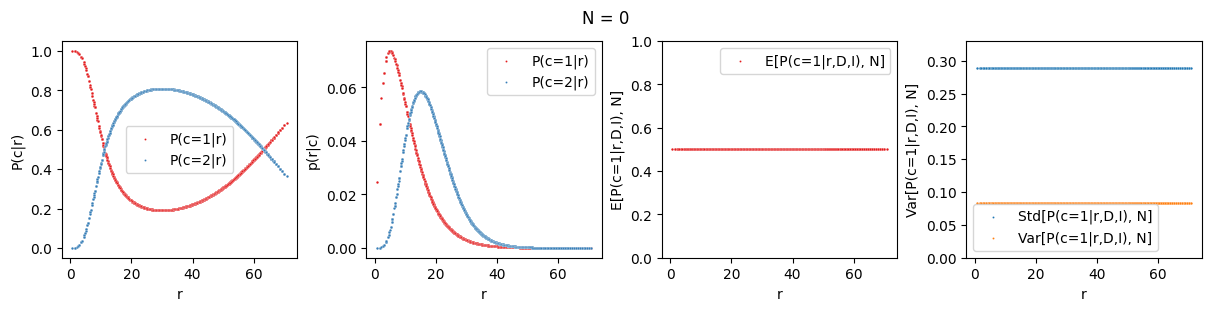

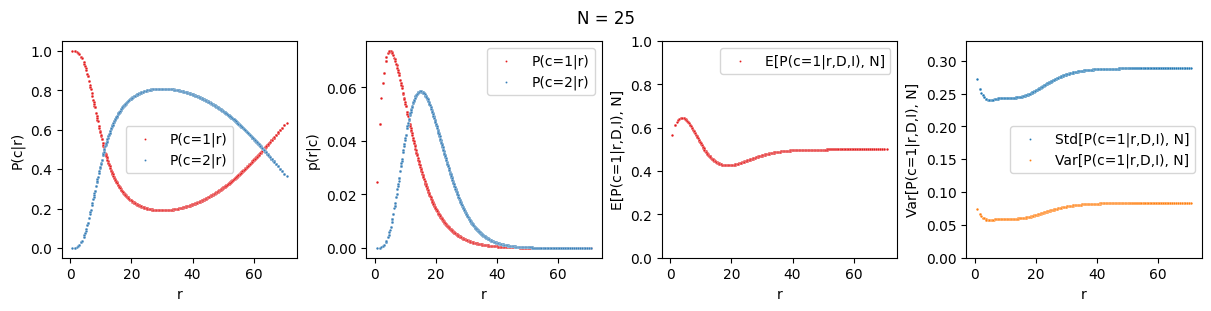

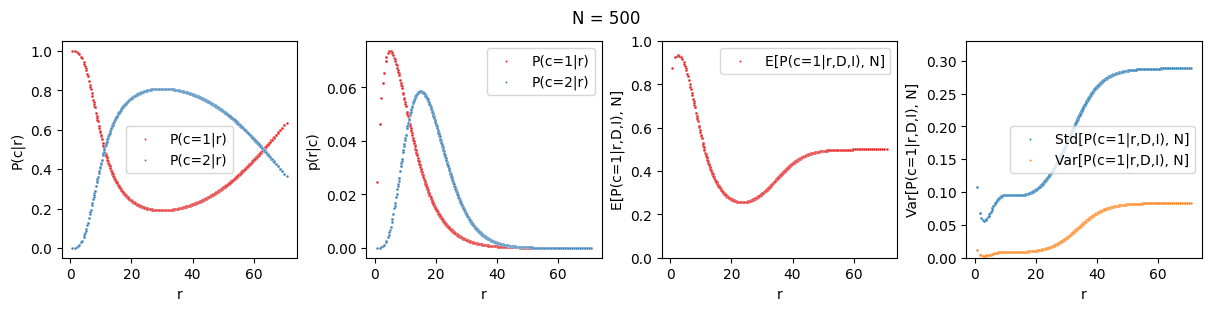

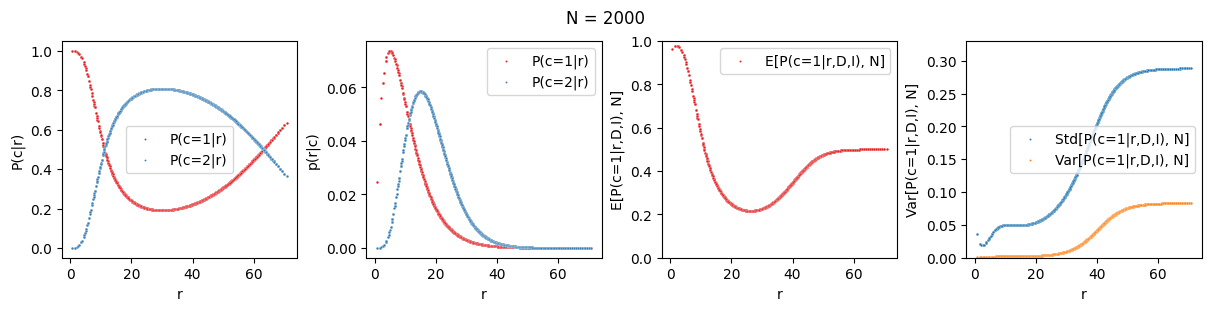

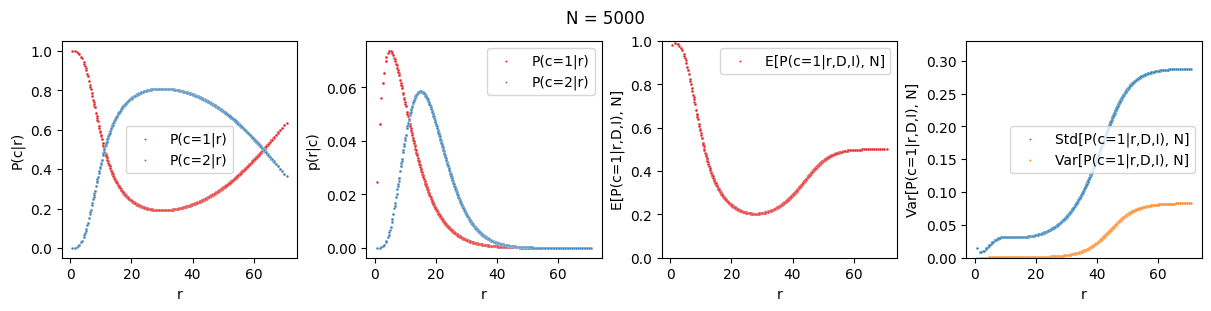

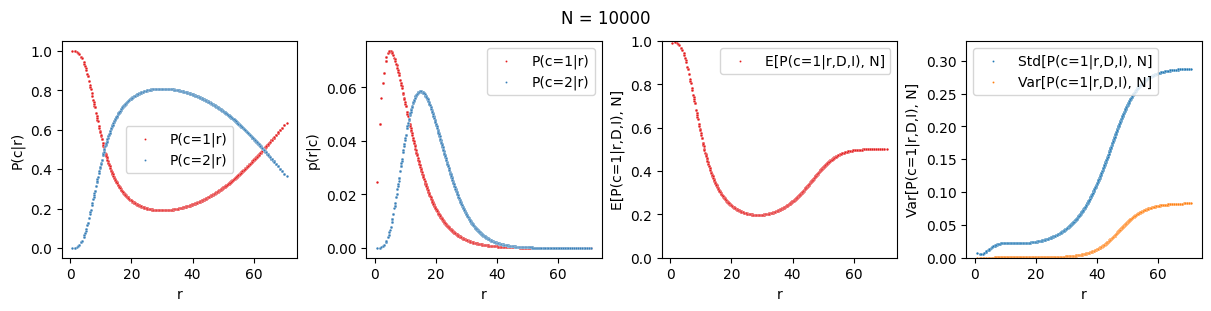

In [15]:
N_data =[0, 25, 500, 2000, 5000, 10000]
for N in N_data:
    grid_df[f"exp_p_r"] = (N*grid_df[f"p_r_given_c0"]*grid_df[f"p_c1"] + 1)/(N*grid_df[f"p_r"]+2)
    grid_df[f"exp_var_r"] = (grid_df[f"exp_p_r"])*(1-grid_df[f"exp_p_r"])/(grid_df[f"p_r"]*N+3)
    grid_df[f"exp_std_r"] = np.sqrt((grid_df[f"exp_p_r"])*(1-grid_df[f"exp_p_r"])/(grid_df[f"p_r"]*N+3))
    fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (12, 3), layout="constrained")
    for i in range(k):
        sn.scatterplot(grid_df, x="r", y=f"p_c{i}_given_r", label=f"P(c={i+1}|r)", ax=axs[0], c=color[i], s=2)
        axs[0].set_ylabel(r"P(c|r)")
        sn.scatterplot(grid_df, x="r", y=f"p_r_given_c{i}", label=f"P(c={i+1}|r)", ax=axs[1], c=color[i], s=2)
        axs[1].set_ylabel(r"p(r|c)")
    sn.scatterplot(grid_df, x="r", y="exp_p_r", ax=axs[2], label="E[P(c=1|r,D,I), N]", s=2, c=color[0])
    axs[2].set_ylabel(r"E[P(c=1|r,D,I), N]")
    axs[2].set_ylim(0,1)
    sn.scatterplot(grid_df, x="r", y="exp_std_r", ax=axs[3], label="Std[P(c=1|r,D,I), N]", s=2)
    sn.scatterplot(grid_df, x="r", y="exp_var_r", ax=axs[3], label="Var[P(c=1|r,D,I), N]", s=2)
    axs[3].set_ylabel(r"Var[P(c=1|r,D,I), N]")
    axs[3].set_ylim(0,0.33)
    for ax in axs:
        ax.legend()
        ax.set_xlabel("r")
        #ax.set_xlim(0, 30)
    fig.suptitle(f"N = {N}")
    print(grid_df[f"exp_p_r"].max())
